In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns 
import matplotlib.pyplot as plt
import EpiClockNBL.src.util as pc_util
pc_consts = pc_util.consts
import EpiClockNBL.Select_fCpGs.util as local_util
import EpiClockNBL.src.maxima as maxima

In [2]:
proj_dir = os.path.join(pc_consts['official_indir'], 'TARGET')

In [3]:
figure_outdir = 'figures'
os.makedirs(figure_outdir, exist_ok=True)

In [4]:
clinical = pd.read_table(os.path.join(proj_dir, 'clinical.annotated.tsv'), index_col=0)

In [5]:
## Import RNA-seq TPM data

# Process gene counts
gene_counts_df = pd.read_table(os.path.join(proj_dir, 'cohort1.rnaseq_raw_counts.tsv'), sep='\t')
gene_counts_df = gene_counts_df.set_index('gene_id')
gene_counts_df = gene_counts_df.rename(columns=pc_util.sampleToPatientID)

# Save gene_name series
# Can use it to map gene IDs to gene names
gene_name = gene_counts_df.pop('gene_name')

# Only consider markers that are nonzero for at least one tumor
nonzero_values = (gene_counts_df != 0).any(axis=1)
gene_counts_df = gene_counts_df.loc[nonzero_values]
gene_name = gene_name.loc[nonzero_values]

In [6]:
gene_counts_log_transformed_df = np.log2(gene_counts_df + 1)
gene_counts_transformed_df = gene_counts_log_transformed_df.apply(lambda col:col - gene_counts_log_transformed_df.mean(axis=1), axis=0)

In [7]:
for gene in ['MKI67', 'MYCN']:
#     clinical[gene] = gene_counts_df.loc[gene_name.index[gene_name==gene]].T
#     clinical[f'log2-{gene}'] = np.log2(1 + clinical[gene])
    clinical[gene] = gene_counts_transformed_df.loc[gene_name.index[gene_name==gene]].T

In [8]:
## Configure graph
sf = 1
figsize = np.array([7, 6])
sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

clinical.name = 'TARGET-NBL'

(array([4.84894e+05, 8.70000e+01, 1.10000e+01, 3.00000e+00, 3.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([      0. ,  126900.4,  253800.8,  380701.2,  507601.6,  634502. ,
         761402.4,  888302.8, 1015203.2, 1142103.6, 1269004. ]),
 <BarContainer object of 10 artists>)

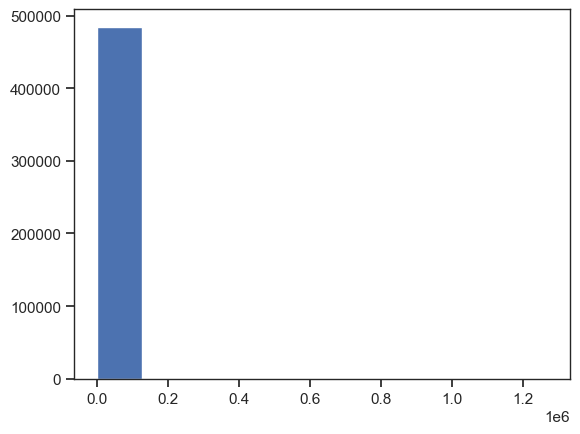

In [9]:
plt.hist(gene_counts_df.loc[gene_name.index].sample(5000).values.flatten())
# plt.xlim()

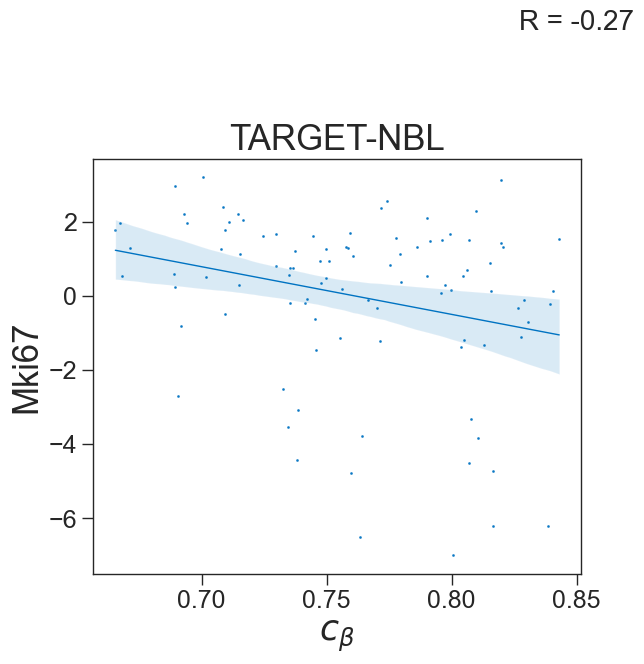

In [10]:
pc_util.saveCorrelationPlot(clinical, var_y='MKI67', restrict=True,
                           var_x='c_beta',
                             outfile=False,
                           text_x=0.85, text_y=7,
                           figsize=figsize * 0.9, labelfontsize=pc_consts['labelfontsize'], ticksfontsize=pc_consts['ticksfontsize'], sf=sf, s=1,
                           color=pc_consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

In [11]:
# List of genes to search
gene_list = gene_counts_transformed_df.index.values 

# List of samples to use
use_samples = np.intersect1d(clinical.index[clinical['in_analysis_dataset']], gene_counts_transformed_df.columns)

c_beta_use_samples = clinical.loc[use_samples, 'c_beta']
gene_counts_transformed_df_use_samples = gene_counts_transformed_df[use_samples]

# Calculate Pearson R between the expression of each gene and c_beta
rvalue_list = []
for i in range(len(gene_list)):
    if i % 5000 == 0:
        print(i)
    
    res = pc_util.pearsonCorrelation(c_beta_use_samples, gene_counts_transformed_df_use_samples.loc[gene_list[i]])
    rvalue_list.append(res.rvalue)

# Save r-values in a Series
rvalue_ser = pd.Series(index=gene_list, data=rvalue_list)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


19259 protein coding genes considered


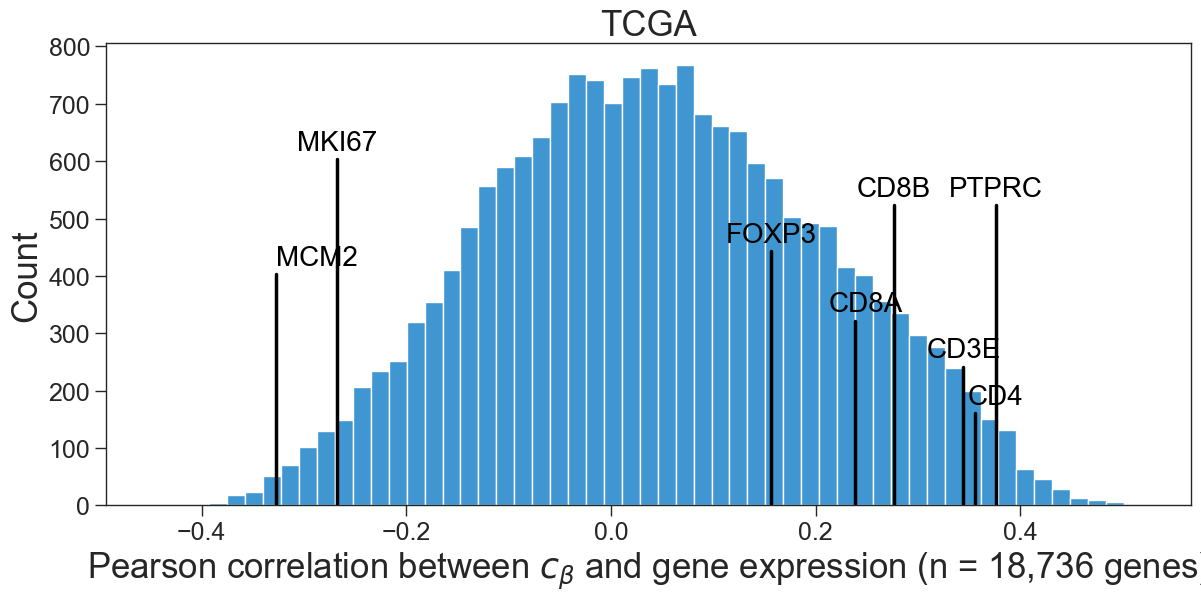

In [ ]:
sf = 1

## Plot distribution of r-values
## Mark location of several genes of interest with vertical lines

# List of protein-coding genes

genenames_proteincoding = pd.read_table(os.path.join(pc_consts['repo_dir'], pc_consts['repo_datadir'], 'genenames.proteincoding.txt'),
                                       low_memory=False, usecols=['symbol']).squeeze('columns').values
print(f'{genenames_proteincoding.shape[0]} protein coding genes considered')

# Only plot r-values of known protein-coding genes
plot_data = rvalue_ser[gene_name.isin(genenames_proteincoding)]

# Create plot
fig, ax = plt.subplots(1, 1, figsize=figsize * [2, 1] * sf)
sns.histplot(ax=ax, x=plot_data,
             color=pc_consts['palette_jco'][0])


# Manually set height of lines and horizontal offset of text from the lines (if necessary)
gene_heights = {
    'MKI67': 0.75,
    'MCM2': 0.5,
    'CD3E': 0.3,
    'CD4': 0.2,
    'CD8A': 0.4,
    'CD8B': 0.65,
    'FOXP3': 0.55,
    'PTPRC': 0.65
}
horiz_offset = {
    'MCM2':0.04,
    'CD8A':0.01,
    'CD4':0.02
}

# Plot vertical lines
y_height = ax.get_ylim()[1]
for gene in gene_heights:
    corr = rvalue_ser.loc[gene_name.index[gene_name == gene]].values
    assert len(corr) == 1     # Sanity check
    
    # 
    x_pos = corr[0]
    if gene in horiz_offset:
        x_pos += horiz_offset[gene]
    ax.axvline(x=corr[0], ymin=0, ymax=gene_heights[gene], color='black', lw=2.5 * sf)
    ax.text(x_pos, (gene_heights[gene] + 0.02)*y_height, gene,
            ha="center", fontfamily='sans-serif',
            fontsize=pc_consts['labelfontsize'] * 0.8 * sf, color='black')

# Customize figure
ax.set_ylabel('Count', fontsize=pc_consts['labelfontsize'] * sf)
ax.set_xlabel(f'Pearson correlation between $c_β$ and gene expression (n = {len(plot_data):,} genes)', fontsize=pc_consts['labelfontsize'] * sf)
ax.set_title(f'TCGA', fontsize=pc_consts['labelfontsize'] * sf)
ax.tick_params(axis='both', labelsize=pc_consts['ticksfontsize'] * sf, width=sf, length=8 * sf)

# Save figure
# fig.savefig(os.path.join(cell_chars_outdir, 'all_gene_correlations.pdf'), format='pdf', pad_inches=0.1)

In [13]:
rvalue_ser.sort_values()

ENSG00000204982.3    -0.498016
ENSG00000244080.3    -0.490559
ENSG00000226562.4    -0.481258
ENSG00000277156.1    -0.462766
ENSG00000215270.3    -0.462410
                        ...   
ENSG00000134996.12    0.499703
ENSG00000163947.12    0.505581
ENSG00000154511.12    0.514194
ENSG00000197702.14    0.519036
ENSG00000225940.7     0.520244
Length: 56128, dtype: float64

In [18]:
import pyperclip


In [19]:
pyperclip.copy('\n'.join(gene_name.loc[rvalue_ser.sort_values().index[:100]]))

In [20]:
pyperclip.copy('\n'.join(gene_name.loc[rvalue_ser.sort_values().index[-100:]]))